# Multi-Armed Bandit

A one-armed bandit is a machine in a casino with a lever arm that is pulled. The machine will return a reward with some pre-programmed probability.  
<img src="one_armed_bandit.jpg" alt="one_armed_bandit" style="height: 200px;"/>  

When there are more than one bandit machines we call this a **multi-armed bandit**. We know that some of the arms have a higher probability of giving a reward and we would like to pull these arms the most often. But to determine which arm returns the best odds we first need to try all the arms out a number of times. This demonstrates the exploitation-exploration trade-off often encountered in reinforcement learning scenarios. The problem can also be mapped to many real world situations (e.g. deciding which is the best restaurant in your local area) so it interesting to look at some solutions to this problem.   
<img src="multi_armed_bandit.jpg" alt="multi_armed_bandit" style="height: 200px;"/>


Here I simulate a multi-armed bandit (MAB) and some agents to play the MAB with different strategies. Each arm in my MAB returns a reward +1 with a probability $p_{success}$ and zero reward with a probability $1-p_{successs}$. The $p_{success}$ for each arm is randomly decided each time the MAB is simulated and the agents do not know the underlying $p_{success}$ values.

First I will create a MAB class and classes for each of the different strategy agents.

## Dependencies

In [1]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import numpy as np
from scipy.stats import beta
from scipy.optimize import root
import ipywidgets as widgets
from IPython.display import display, clear_output
import functools 
import time

## The MAB and agent classes

In [2]:
# The environemnt
class MABEnv():
    """Multi-Armed Bandit class. Builds a MAB with n_arms arms."""
    def __init__(self, n_arms=5):
        # build MAB with n_arms
        self.n_arms = n_arms
        self.reset()
        # output for render function
        self.output = widgets.Output()
        display(self.output)

                     
    def reset(self):
        # set probability of success for each arm. even spread
        dp = 1/(self.n_arms+1)
        self.p_success = dp*np.arange(1, self.n_arms+1)
        np.random.shuffle(self.p_success)
        self.p_max = max(self.p_success)
        self.arg_min = np.argmax(-self.p_success)
        
        ## store info
        # arm successes
        self.reward_history = [[0, 0] for _ in range(self.n_arms)]   # [n,k] = [number of trials, number of successes]
        # turn by turn rewards
        self.rewards = []
        # expected regret due to particular strategy
        self.expected_regret = []
        
    def step(self, arm, render=False):
        # pull desired arm
        reward = np.random.binomial(1, self.p_success[arm])
        
        ## store info 
        self.reward_history[arm][0] += 1
        self.reward_history[arm][1] += reward
        self.rewards.append(reward)
        self.expected_regret.append(self.p_max - reward)
        
        return reward
   
        
    def render(self, show_mean=True, show_dist=True, show_actual_p=True):
        ## plots P(p_success|n,k) for each arm      
        
        with self.output:
            fig, axs = plt.subplots(self.n_arms, 1, sharex=True, figsize=(10, 10))
            
            for i_arm in range(self.n_arms):
                ax = axs[i_arm] 
                # plot expected distribution of p_success.
                # This is a beta distribution with alpha=k+1, beta=n-k+1
                n, k = self.reward_history[i_arm]
                
                # plot
                if show_actual_p:
                    actual_p = self.p_success[i_arm]
                    ax.axvline(actual_p, c='k', ls='--', label='Actual $p_{success}$')
                if show_dist:
                    #pdf
                    p_scan = np.linspace(0,1,101)
                    p_pdf = beta.pdf(p_scan, k + 1,n - k + 1)
                    # ucb.
                    p_cdf = beta.cdf(p_scan, k + 1,n - k + 1)
                    ucb_index = np.argmin(abs(p_cdf - 0.95))
                    ucb = p_scan[ucb_index]
                    # plot
                    ax.plot(p_scan, p_pdf, c='r', label='$P(p_{success}|n,k)$')
                    ax.axvline(ucb, c='r', ls=':', label='95% UCB')            
                if show_mean:
                    if n != 0:
                        mean_reward = k/n
                    else:
                        mean_reward = 0.5
                    ax.axvline(mean_reward, c='b', ls='--', label='Mean reward')  
                
                # make pretty
                ax.axes.set_yticks([])
                ax.set_ylabel("Arm " + str(i_arm+1))
                ax.set_xlim([-0.05,1.05])
                info_string = "n = " + str(n) + "\n" + "k = " + str(k)
                anchored_text = AnchoredText(info_string, loc=2)
                ax.add_artist(anchored_text)
        
        
            axs[0].set_title("Results")
            axs[-1].set_xlabel("$p_{success}$")
            
            # add legend to lowest probability arm so there is space on right of plot
            axs[self.arg_min].legend(loc='upper right')

            # clear any output from previous call
            clear_output(wait=True)
            plt.show(fig)


## Agents
    
class RandomAgent():
    """This agent chooses an arm at random"""
    def __init__(self, env):
        self.n_arms = env.n_arms
        
    def choose_arm(self):
        choice = np.random.randint(0, self.n_arms)
        return choice
    
    
class OmniscientAgent():
    """This agent only pulls the best arm - not possible in reality"""
    def __init__(self, env):
        self.env = env
        
    def choose_arm(self):
        # This agent is cheating by looking at the p_success values for each arm
        self.best_arm = np.argmax(self.env.p_success)
        choice = self.best_arm
        return choice
    
    
class EpsilonGreedyAgent():
    """This agent pulls the arm with the best mean reward so far.
        Except with probability epsilon it pulls a random arm to aid exploration."""
    def __init__(self, env, epsilon=0.05):
        self.n_arms = env.n_arms
        self.epsilon = epsilon
        self.env = env
        
    def choose_arm(self):
        ## Mean reward for each arm is k/n
        
        ## Must play each arm once before comparing
        for arm in range(self.n_arms):
            n = self.env.reward_history[arm][0]
            if n == 0:
                choice = arm
                return choice
        
        mean_rewards = [k/n for [n,k] in self.env.reward_history]
        
        random_number = np.random.random()
        if random_number < (1 - self.epsilon):
            # Most of the time choose arm with largest expected p_success
            choice = np.argmax(mean_rewards)
        else: 
            choice = np.random.randint(0, self.n_arms)
        
        return choice
    
    
class UCBAgent():
    """This agent models the probaility distribution of p_success of each arm given the data so far.
        i.e P(p_success|n,k). It then chooses the arm with the higher upper confidence bound (ucb)."""
    def __init__(self, env, epsilon=0.05):
        self.n_arms = env.n_arms
        self.env = env        
        
    def choose_arm(self):
        ## Model p_success with Beta distribution.
        
        ## Must play each arm once before comparing
        for arm in range(self.n_arms):
            n = self.env.reward_history[arm][0]
            if n == 0:
                choice = arm
                return choice
            
        # Choose arm with highest 95% upper confidence limit
        p_scan = np.linspace(0,1,101)
        beta_ucbs = np.zeros(self.n_arms)
        for arm in range(self.n_arms):
            n, k = self.env.reward_history[arm]
            # calculate ucb numerically with cumulative distribution function (cdf).
            p_cdf = beta.cdf(p_scan, k + 1,n - k + 1)
            ucb_index = np.argmin(abs(p_cdf - 0.95))
            ucb = p_scan[ucb_index]
            beta_ucbs[arm] = ucb
        
        choice = np.argmax(beta_ucbs)
    
        return choice
    
    
class HumanAgent():
    """This allows a user to play the MAB via widget buttons."""
    def __init__(self, env, render_options={'show_mean': False, 'show_dist': False}):
        self.n_arms = env.n_arms
        self.env = env
        # widget buttons for each arm
        self.buttons = [widgets.Button(description=str(i_arm+1)) for i_arm in range(self.n_arms)]
        # output for win/lose display
        output = widgets.Output(layout=widgets.Layout(height='30px')) # for feedback
        output2 = widgets.Output(layout=widgets.Layout(height='60px')) # for running total
        display(widgets.VBox(self.buttons + [output, output2]))
        
        # optionally render the info on previous arm pulls
        self.render_options = render_options
        if self.render_options['show_mean'] or self.render_options['show_dist']:
            env.render(show_mean=self.render_options['show_mean'], 
                       show_dist=self.render_options['show_dist'], 
                       show_actual_p=False)
        
        # function called when button pushed
        def store_choice(_, i_button):
            reward = self.env.step(i_button)

            # feedback for user
            with output:
                print("...")
                time.sleep(0.2)
                clear_output()
                if reward == 0:
                    print("Not this time :(")
                elif reward == 1:
                    print("WINNER! :)")
                time.sleep(1)
                clear_output()
            with output2:
                print("Number of goes: " + str(len(env.rewards)))
                print("Total reward: " + str(sum(env.rewards)))
                clear_output(wait=True)
            
            # optionally render the info on previous arm pulls
            if self.render_options['show_mean'] or self.render_options['show_dist']:
                env.render(show_mean=self.render_options['show_mean'], 
                           show_dist=self.render_options['show_dist'], 
                           show_actual_p=False)
        
        # tell the buttons what to do when pushed
        for i_button in range(self.n_arms):
            button = self.buttons[i_button]
            button.on_click(functools.partial(store_choice, i_button=i_button))


## Have a go

1. First of all have a go yourself. How well do you do after 20 presses?   
2. Then try setting 'show_mean'=True to see your average reward for each arm as you go. Does this info change how you play the game?   (You'll have to rerun the cell to reset the environment)
3. Now try setting 'show_dist'=True. This will plot the a probability distributon for $p_{success}$ with a 95% upper confidence bound. Does this change your strategy again? Did your score improve? (Remember to rerun the cell each time you want to start from zero.)


In [5]:
env = MABEnv(n_arms=4)
agent = HumanAgent(env, render_options={'show_mean': True, 'show_dist': True})

Output()

Hopefully you are now getting a gist for the problem, the importance of exploration vs exploitation and you may already have worked a decent strategy. 

## Different solutions 

Here we present 4 different solutions to the MAB problem and compare them. The standard way to compare MAB algorithms is to look at their _regret_ which I will explain momentarily. 

The first solution I will present is a cheat. This is an omniscient agent that always knows the correct arm to pull for the highest expected reward. Note that this doesn't work in real life. The regret of the omniscient agent is 0 by definition as it never made a mistake and chose a suboptimal arm. 

The regret for other agents then is the difference between the expected reward from the optimal arm and the expected reward from the arm we actually pulled. 

The 3 other agents are:

1. A random agent that chooses arms at random

2. An epsilon greedy agent which calculates the mean reward for each arm and chooses the arm with highest mean reward. Except with a probablity epsilon it chooses a random arm to aid exploration. 

3. An upper confidence bound (UCB) agent which estimates a probability distribution for $p_{success}$ for each arm and chooses the arm with the highest UCB.


In [6]:
# Numerical experiment to measure the regret for each agent over multiple runs. 

agents = [OmniscientAgent, RandomAgent, EpsilonGreedyAgent, UCBAgent]

n_arms = 4
total_pulls = 200
n_agents = len(agents)
n_runs = 20

regret_data = np.zeros((n_agents, n_runs, total_pulls))

env = MABEnv(n_arms=n_arms)

for i_agent in range(n_agents):
    agent = agents[i_agent](env)
    
    for i_run in range(n_runs):
        env.reset()
    
        for _ in range(total_pulls):
            
            action = agent.choose_arm()
            reward = env.step(action)

        regret_data[i_agent, i_run, :] = env.expected_regret


Output()

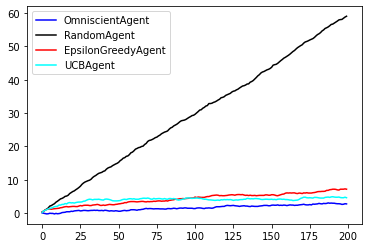

In [7]:
# Plot the average regret for each agent

colors = ['b', 'k', 'r', 'cyan']

x = range(total_pulls)
mean_regret = regret_data.mean(axis=1)


plt.figure()
for i_agent in range(n_agents):
    y = np.cumsum(mean_regret[i_agent,:])
    plt.plot(x, y, c=colors[i_agent], label=str(agents[i_agent].__name__))
plt.legend();



So we see that the UCB agent performs best. (Except for the cheater omniscient agent - Note the omniscient agent regret is not exactly zero as it has been simulated through random trials.)

If you want to see how the UCB agent makes its choices turn by turn then run this next cell.

In [9]:
## test render

n_arms = 3
total_pulls = 20
env = MABEnv(n_arms=n_arms)
agent = UCBAgent(env)


for _ in range(total_pulls):
    action = agent.choose_arm()
    reward = env.step(action)
    env.render()    
    time.sleep(1)


Output()

## Conclusion

Here I have explained the multi-armed bandit problem and a few of the known solutions. This problem teaches us a lot about the exploration-exploitation trade off and is applicable to many real-world situations.